# 🚴‍♂️ Bike Sharing Demand Prediction

## 📌 Project Overview
This project is part of Level 2 in the Real ML Roadmap. The goal is to predict the total number of bike rentals (`count`) on a given day based on various features like weather, temperature, humidity, windspeed, and datetime.

We will:
- Explore and preprocess the dataset
- Perform feature engineering (especially from datetime)
- Train and evaluate different regression models
- Use metrics like RMSE, MAE, and R² score to compare performance

## 🧠 Dataset
- Source: [Kaggle - Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand)
- Shape: ~11,000 rows × 12 columns
- Target: `count` (total number of bike rentals)

## 📅 Features
- **datetime**: timestamp of the record
- **season**: 1 = spring, 2 = summer, 3 = fall, 4 = winter
- **holiday**: whether the day is a holiday
- **workingday**: whether the day is a working day
- **weather**: 1 = clear, 4 = heavy rain/snow
- **temp** / **atemp**: actual and "feels like" temperatures
- **humidity** and **windspeed**
- **casual**, **registered**, and **count**: user types (target = count)

> 🛑 We'll drop `casual` and `registered` as they directly sum up to `count` and would cause data leakage.

---


In [32]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set styles
sns.set(style="whitegrid")
%matplotlib inline

# Load the dataset
df = pd.read_csv(r"D:\bike-sharing-demand\train.csv")  # Assuming the file is named 'train.csv'


In [33]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [34]:
df.isnull().sum()


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Feature Engineering

In [35]:
# You should definitely add this
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['datetime'].dt.weekday
df.drop('datetime', axis=1, inplace=True)


Explatory Data Analysis

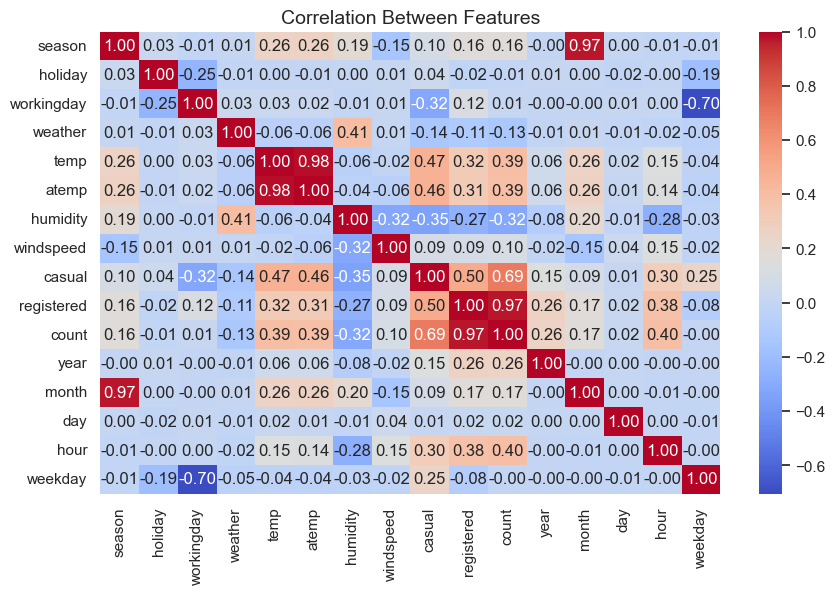

In [36]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Features", fontsize=14)
plt.show()


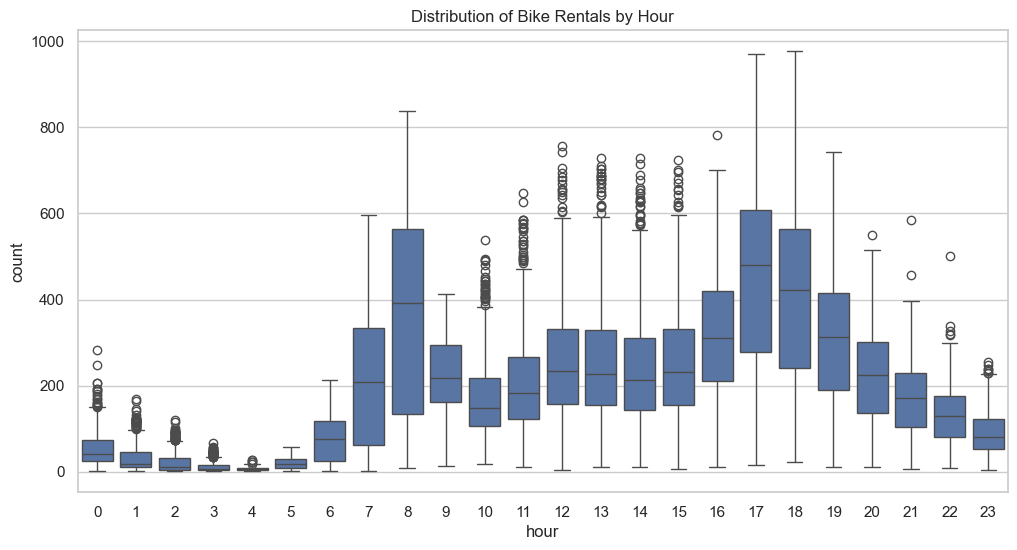

In [37]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='hour', y='count')
plt.title("Distribution of Bike Rentals by Hour")
plt.show()


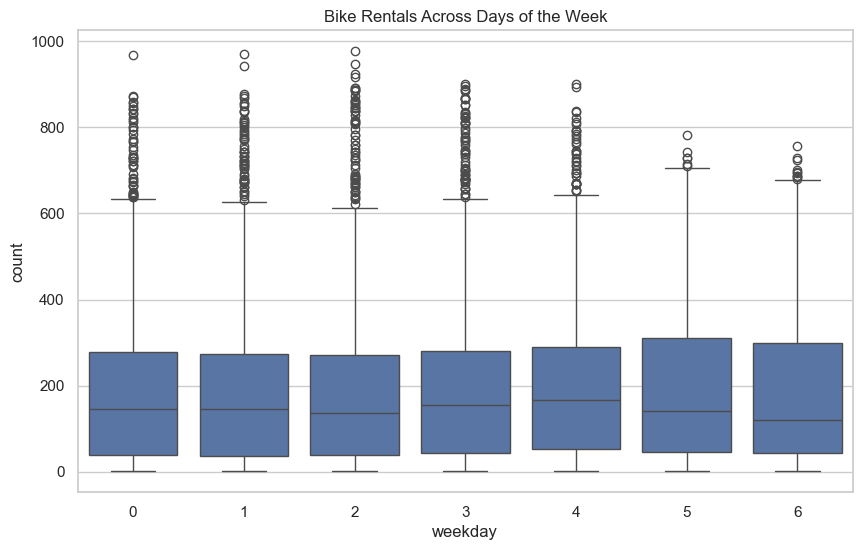

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='weekday', y='count')
plt.title("Bike Rentals Across Days of the Week")
plt.show()


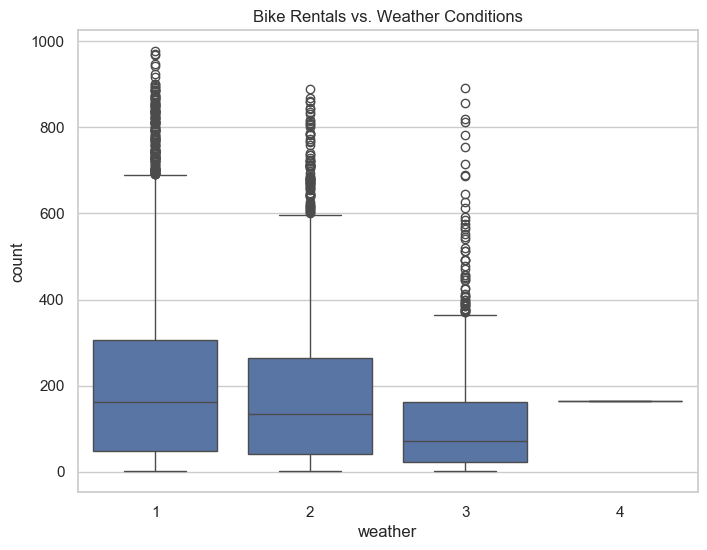

In [39]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='weather', y='count')
plt.title("Bike Rentals vs. Weather Conditions")
plt.show()

# Weather codes:

# 1 = Clear

# 2 = Mist

# 3 = Light Snow or Rain

# 4 = Heavy Rain/Snow — very rare

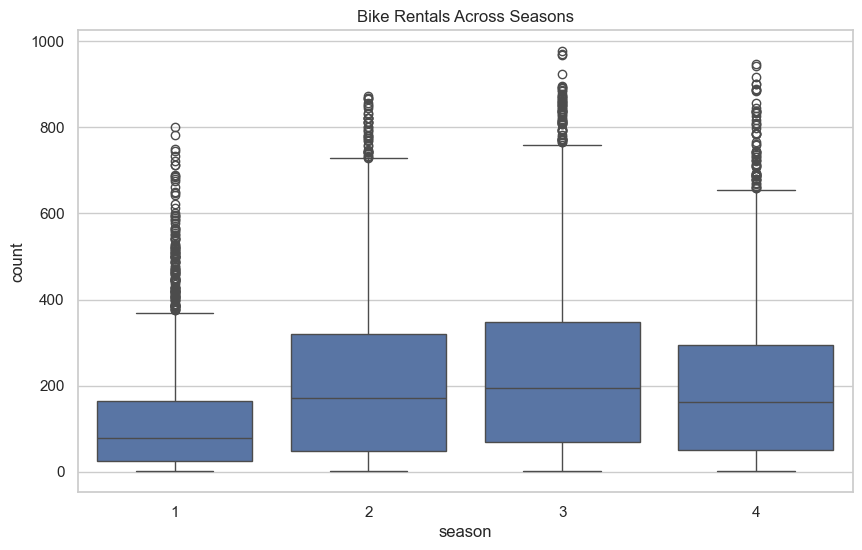

In [40]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='season', y='count')
plt.title("Bike Rentals Across Seasons")
plt.show()


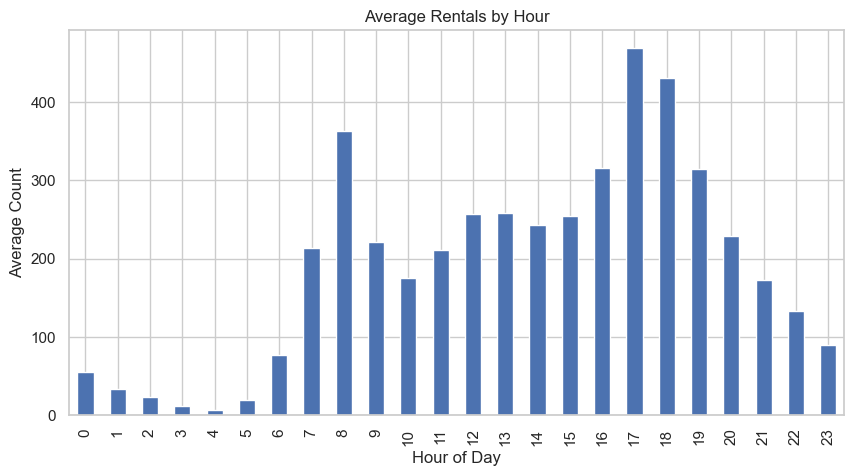

In [41]:
hourly_avg = df.groupby('hour')['count'].mean()
hourly_avg.plot(kind='bar', figsize=(10,5), title='Average Rentals by Hour')
plt.ylabel("Average Count")
plt.xlabel("Hour of Day")
plt.show()


Preprocessing

In [42]:
df.drop(['casual', 'registered'], axis=1, inplace=True)


In [43]:
df = pd.get_dummies(df, columns=['season', 'weather', 'month', 'hour', 'weekday', 'year'], drop_first=True)

In [44]:
X = df.drop(['count'], axis=1)
y = df['count']

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training and Evaluation

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train the model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = lr.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MAE  : {mae:.2f}")
print(f"Linear Regression RMSE : {rmse:.2f}")
print(f"Linear Regression R²   : {r2:.4f}")


Linear Regression MAE  : 74.06
Linear Regression RMSE : 100.05
Linear Regression R²   : 0.6967


In [50]:
from sklearn.tree import DecisionTreeRegressor

# Create and train the model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)

# Predict
y_pred_dt = dt.predict(X_test_scaled)

# Evaluate
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree MAE  : {mae_dt:.2f}")
print(f"Decision Tree RMSE : {rmse_dt:.2f}")
print(f"Decision Tree R²   : {r2_dt:.4f}")

# from sklearn.tree import plot_tree

# plt.figure(figsize=(20,10))
# plot_tree(dt, filled=True, max_depth=3, feature_names=X.columns)
# plt.show()


Decision Tree MAE  : 44.70
Decision Tree RMSE : 73.27
Decision Tree R²   : 0.8374


Decision Tree Hyperparameter tuning

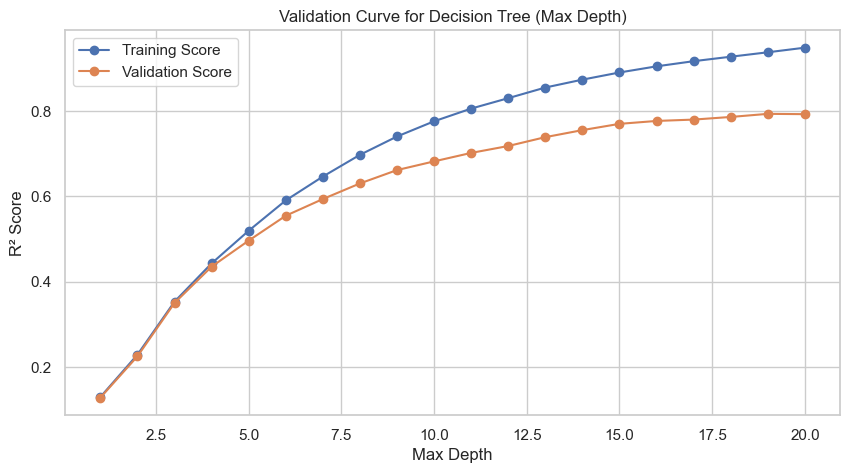

max_depth=1, validation R²=0.1283
max_depth=2, validation R²=0.2252
max_depth=3, validation R²=0.3503
max_depth=4, validation R²=0.4353
max_depth=5, validation R²=0.4964
max_depth=6, validation R²=0.5547
max_depth=7, validation R²=0.5938
max_depth=8, validation R²=0.6304
max_depth=9, validation R²=0.6617
max_depth=10, validation R²=0.6821
max_depth=11, validation R²=0.7020
max_depth=12, validation R²=0.7181
max_depth=13, validation R²=0.7389
max_depth=14, validation R²=0.7554
max_depth=15, validation R²=0.7701
max_depth=16, validation R²=0.7769
max_depth=17, validation R²=0.7801
max_depth=18, validation R²=0.7862
max_depth=19, validation R²=0.7935
max_depth=20, validation R²=0.7928


In [52]:
from sklearn.model_selection import validation_curve

# Range of max_depth values to try
param_range = range(1, 21)

# Train on each depth and get training + test scores
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state=42),
    X_train_scaled,
    y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="r2",
    cv=3
)

# Calculate mean scores across folds
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(param_range, train_mean, label="Training Score", marker='o')
plt.plot(param_range, test_mean, label="Validation Score", marker='o')
plt.xlabel("Max Depth")
plt.ylabel("R² Score")
plt.title("Validation Curve for Decision Tree (Max Depth)")
plt.legend()
plt.grid(True)
plt.show()

for depth, score in zip(param_range, test_mean):
    print(f"max_depth={depth}, validation R²={score:.4f}")


In [53]:
# Train the tuned decision tree
dt_tuned = DecisionTreeRegressor(max_depth=19, random_state=42)
dt_tuned.fit(X_train_scaled, y_train)

# Predict
y_pred_dt_tuned = dt_tuned.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_dt_tuned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt_tuned))
r2 = r2_score(y_test, y_pred_dt_tuned)

print(f"Tuned Decision Tree MAE  : {mae:.2f}")
print(f"Tuned Decision Tree RMSE : {rmse:.2f}")
print(f"Tuned Decision Tree R²   : {r2:.4f}")


Tuned Decision Tree MAE  : 50.51
Tuned Decision Tree RMSE : 79.13
Tuned Decision Tree R²   : 0.8103


In [54]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE  : {mae_rf:.2f}")
print(f"Random Forest RMSE : {rmse_rf:.2f}")
print(f"Random Forest R²   : {r2_rf:.4f}")


Random Forest MAE  : 35.21
Random Forest RMSE : 54.17
Random Forest R²   : 0.9111


Tuning Random Forest using GridSearch Cv

In [55]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create base model
rf_base = RandomForestRegressor(random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,   # Use all cores
    verbose=1
)

# Fit to training data
grid_search.fit(X_train_scaled, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [56]:
y_pred_best = best_rf.predict(X_test_scaled)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Final Tuned RF MAE  : {mae_best:.2f}")
print(f"Final Tuned RF RMSE : {rmse_best:.2f}")
print(f"Final Tuned RF R²   : {r2_best:.4f}")


Final Tuned RF MAE  : 39.33
Final Tuned RF RMSE : 59.31
Final Tuned RF R²   : 0.8934
